In [1]:
!pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 118.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 65.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 55.1 MB/s eta 0:00:00
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16426 sha256=2737a6e2aa4d8fc0adecf1f414921dff66891163b62ec0f7

In [16]:
import torch
import torch.nn as nn
from efficientnet_pytorch import EfficientNet
from torch.utils.data import Dataset
from PIL import Image
import pandas as pd
import os
from torchvision import transforms
from torch.utils.data import random_split, DataLoader
import torch.optim as optim
import zipfile
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from torch.optim.lr_scheduler import ReduceLROnPlateau
import time
import math

In [3]:
print(f"Parallel process available: {os.cpu_count()}")

Parallel process available: 2


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# about 3 min
import zipfile

zip_path = "/content/drive/MyDrive/archive.zip"
extract_path = "/content/archive_unzipped"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [26]:
class BoneAgeDataset(Dataset):
    def __init__(self, csv_path, image_dir, transform=None):
        self.df = pd.read_csv(csv_path)
        self.image_dir = image_dir
        self.transform = transform
        self.sex_map = {"True": 0, "False": 1}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.image_dir, str(row['id']))
        img_path_ext = img_path + ".png"
        image = Image.open(img_path_ext).convert("RGB")
        if self.transform:
            image = self.transform(image)

        #print(self.sex_map[str(row["male"])])
        sex = self.sex_map[str(row["male"])]
        age = row['boneage']

        return image, torch.tensor(sex), torch.tensor(age).float(), str(row['id'])

In [27]:
# do not use ATM this class
class TestBoneAgeDataset(Dataset):
    def __init__(self, csv_path, image_dir, transform=None):
        self.df = pd.read_csv(csv_path)
        self.image_dir = image_dir
        self.transform = transform
        self.sex_map = {"TRUE": 0, "FALSE": 1}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.image_dir, str(row['id']))
        print(f"IMMAGINE: {img_path}")
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        #print(self.sex_map[str(row["male"])])
        sex = self.sex_map[str(row["male"]).upper()]

        return image, torch.tensor(sex), str(row['id'])

In [28]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [29]:
class BoneAgeRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = EfficientNet.from_pretrained('efficientnet-b0')
        for param in self.backbone.parameters():
            param.requires_grad = False

        self.backbone._fc = nn.Identity()
        self.fc = nn.Sequential(
            nn.Linear(1280 + 1, 128),  # 1280 = output di EfficientNet-B0
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 1)  # Output: età in mesi
        )

    def forward(self, image, sex):
        x = self.backbone(image)
        sex = sex.view(-1, 1).float()
        x = torch.cat([x, sex], dim=1)
        return self.fc(x)

In [30]:
dataset = BoneAgeDataset(csv_path="/content/archive_unzipped/boneage-training-dataset.csv",
                         image_dir="/content/archive_unzipped/boneage-training-dataset/boneage-training-dataset",
                         transform=transform)

total_size = len(dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, num_workers=2, pin_memory=True)

In [31]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler,
                num_epochs=25, save_path='best_model.pth', patience=3):
    best_val_loss = float('inf')
    train_losses, val_losses = [], []
    patience_counter = 0

    for epoch in range(num_epochs):
        epoch_start = time.time()
        model.train()
        running_loss = 0.0
        for images, sexes, ages, _ in train_loader:
            images, sexes, ages = images.to(device), sexes.to(device), ages.to(device).view(-1, 1)
            optimizer.zero_grad()
            loss = criterion(model(images, sexes), ages)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
        train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, sexes, ages, _ in val_loader:
                images, sexes, ages = images.to(device), sexes.to(device), ages.to(device).view(-1, 1)
                val_loss += criterion(model(images, sexes), ages).item() * images.size(0)
        val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(val_loss)

        scheduler.step(val_loss)

        epoch_time = time.time() - epoch_start
        print(f"{'-'*100}")
        print(f"Epoch {epoch+1}, took: {epoch_time:.1f}s: Train MAE {train_loss:.2f} | Val MAE {val_loss:.2f}, Learning rate: {optimizer.param_groups[0]['lr']}")

        if val_loss < best_val_loss:
            print("Saving best model...")
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), save_path)
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping")
                break

    # Plot
    plt.plot(train_losses, label="Train MAE")
    plt.plot(val_losses, label="Val MAE")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("MAE")
    plt.grid()
    plt.show()

In [32]:
def predict_test(model, test_loader, output_csv='prediction_test.csv'):
    model.eval()
    results = []
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, sexes, ages, ids in test_loader:
            images, sexes = images.to(device), sexes.to(device)
            preds = model(images, sexes).cpu().numpy()
            y_pred.extend(preds)
            y_true.extend(ages)
            for id, pred in zip(ids, preds):
                results.append((id, round(float(pred), 2)))

    import csv
    with open(output_csv, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['id', 'boneage'])
        for row in results:
            writer.writerow(row)

    print(f"Predizioni salvate in: {output_csv}")

    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred) ** 0.5
    r2 = r2_score(y_true, y_pred)

    print(f"Metriche di valutazione:")
    print(f"MAE:  {mae:.2f} mesi")
    print(f"RMSE: {rmse:.2f} mesi")
    print(f"R²:   {r2:.3f}")

In [33]:
def predict_submission(model, submission_loader, output_csv='submission.csv'):
    model.eval()
    results = []

    with torch.no_grad():
        for images, sexes, ids in submission_loader:
            images, sexes = images.to(device), sexes.to(device)
            preds = model(images, sexes).cpu().numpy()
            for id, pred in zip(ids, preds):
                results.append((id, round(float(pred), 2)))

    import csv
    with open(output_csv, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['id', 'boneage'])
        for row in results:
            writer.writerow(row)

    print(f"Predizioni salvate in: {output_csv}")

Device: cuda
Loaded pretrained weights for efficientnet-b0
modello inizializzato


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


----------------------------------------------------------------------------------------------------
Epoch 1, took: 489.5s: Train MAE 54.08 | Val MAE 37.03, Learning rate: 0.001
Saving best model...
----------------------------------------------------------------------------------------------------
Epoch 2, took: 418.0s: Train MAE 33.29 | Val MAE 29.68, Learning rate: 0.001
Saving best model...
----------------------------------------------------------------------------------------------------
Epoch 3, took: 416.7s: Train MAE 28.88 | Val MAE 24.97, Learning rate: 0.001
Saving best model...
----------------------------------------------------------------------------------------------------
Epoch 4, took: 416.5s: Train MAE 26.88 | Val MAE 23.85, Learning rate: 0.001
Saving best model...
----------------------------------------------------------------------------------------------------
Epoch 5, took: 414.6s: Train MAE 25.78 | Val MAE 22.82, Learning rate: 0.001
Saving best model...
-----

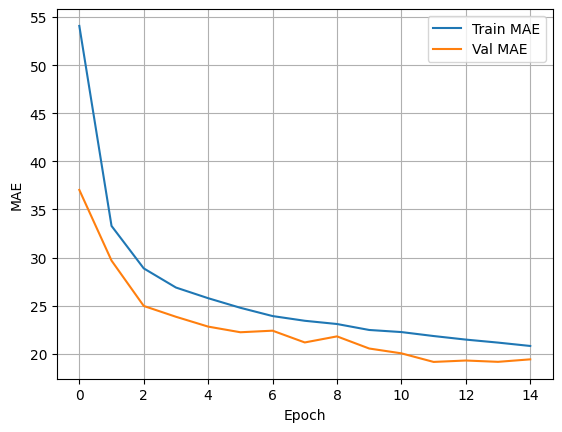

In [34]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# Model
model = BoneAgeRegressor().to(device)
model = torch.compile(model)
print(f"modello inizializzato")

# Loss, ottimizzatore e scheduler
criterion = nn.L1Loss()
#optimizer = optim.Adam(model.parameters(), lr=1e-3)
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, cooldown=1, min_lr=1e-6, verbose=True)

# Allenamento
train_model(model, train_loader, val_loader, criterion, optimizer, scheduler)

In [39]:
# Carica miglior modello e predici
model_loaded = BoneAgeRegressor().to(device)
model_loaded = torch.compile(model_loaded)
model_loaded.load_state_dict(torch.load("best_model.pth"))
predict_test(model_loaded, test_loader)

Loaded pretrained weights for efficientnet-b0


/tmp/ipython-input-32-1214416790.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  results.append((id, round(float(pred), 2)))


Predizioni salvate in: prediction_test.csv
Metriche di valutazione:
MAE:  18.03 mesi
RMSE: 23.15 mesi
R²:   0.684


In [40]:
submission_dataset = TestBoneAgeDataset(csv_path="/content/drive/MyDrive/test/test.csv",
                         image_dir="/content/drive/MyDrive/test",
                         transform=transform)
submission_loader = DataLoader(submission_dataset, batch_size=32)
model_loaded_1 = BoneAgeRegressor().to(device)
model_loaded_1 = torch.compile(model_loaded_1)
model_loaded_1.load_state_dict(torch.load("best_model.pth"))
predict_submission(model_loaded_1, submission_loader)

Loaded pretrained weights for efficientnet-b0
IMMAGINE: /content/drive/MyDrive/test/1.png
IMMAGINE: /content/drive/MyDrive/test/2.png
IMMAGINE: /content/drive/MyDrive/test/3.png
IMMAGINE: /content/drive/MyDrive/test/4.png
IMMAGINE: /content/drive/MyDrive/test/5.png
IMMAGINE: /content/drive/MyDrive/test/6.png
IMMAGINE: /content/drive/MyDrive/test/7.png
IMMAGINE: /content/drive/MyDrive/test/8.png
IMMAGINE: /content/drive/MyDrive/test/9.png
IMMAGINE: /content/drive/MyDrive/test/10.png
IMMAGINE: /content/drive/MyDrive/test/11.png
IMMAGINE: /content/drive/MyDrive/test/12.png
IMMAGINE: /content/drive/MyDrive/test/13.png
IMMAGINE: /content/drive/MyDrive/test/14.png
IMMAGINE: /content/drive/MyDrive/test/15.png
IMMAGINE: /content/drive/MyDrive/test/16.png
IMMAGINE: /content/drive/MyDrive/test/17.png
IMMAGINE: /content/drive/MyDrive/test/18.png
IMMAGINE: /content/drive/MyDrive/test/19.png
IMMAGINE: /content/drive/MyDrive/test/20.png
IMMAGINE: /content/drive/MyDrive/test/21.png
IMMAGINE: /content

/tmp/ipython-input-33-4141735002.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  results.append((id, round(float(pred), 2)))


IMMAGINE: /content/drive/MyDrive/test/33.png
Predizioni salvate in: submission.csv


/tmp/ipython-input-33-4141735002.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  results.append((id, round(float(pred), 2)))
